In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

import sys
import os
sys.path.insert(0, os.path.abspath('../../modules'))

from helper_functions import feature_reduction_decision_tree, feature_reduction_x, count_nan_features, heatmap

from datetime import datetime

In [2]:
#balanced_dataset = '../../data/training/ber-rating-dataset-final-split_0.csv'
#balanced_dataset = '../../data/training/ber-rating-dataset-final.csv'
balanced_dataset = '../../data/training/ber-rating-dataset-final-split_1.csv'

df = pd.read_table(balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="skip", low_memory=False)

df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)

print(df.shape)

(27628, 212)


In [3]:
df.head()

,index,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorAreasqm,UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,2829,Co. Louth,Semi-detached house,1979,Existing,D1,228.19,94.58,0.46,0.21,...,6.0,5.0,147019052,0.000222,0.012347,NaN,NaN,NaN,NaN,NaN
1,17354,Co. Leitrim,Detached house,1995,Existing,B2,122.04,250.00,0.34,0.39,...,NaN,NaN,117015002,0.050000,0.050000,0.156,34319.20,5628.0,1.225,0.915
2,7914,Co. Monaghan,Detached house,1965,Existing,F,411.02,121.88,0.65,1.04,...,NaN,NaN,177058001,0.050000,0.050000,0.000,49850.70,0.0,2.917,2.322
3,14408,Co. Dublin,Ground-floor apartment,2004,Existing,C1,172.69,50.00,0.55,0.00,...,NaN,NaN,NaN,NaN,NaN,0.000,8634.67,0.0,0.591,0.889
4,6367,Co. Sligo,Detached house,1974,Existing,A3,64.11,76.28,0.22,0.13,...,NaN,NaN,207051001,0.055882,0.055882,0.582,4890.16,6815.4,0.212,0.328


In [4]:
df.describe()

,index,Year_of_Construction,BerRating,GroundFloorAreasqm,UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,...,ThirdWallUValue,ThirdWallAgeBandId,ThirdWallTypeId,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
count,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,27628.000000,...,5855.000000,5827.000000,5850.000000,2.416700e+04,24167.000000,24503.000000,24503.000000,24503.000000,25563.00000,25563.000000
mean,9703.700992,1978.787281,219.315822,123.247845,0.784514,0.491442,0.455043,2.432107,2.240975,104.592750,...,0.852286,6.452205,7.326838,3.783775e-02,0.038679,0.163964,24201.322088,2889.816144,1.42838,1.276184
std,5695.665675,39.174980,172.405325,69.352347,0.653338,0.624382,0.265329,0.935848,1.038583,62.367449,...,0.659588,3.154654,2.996866,3.147662e-02,0.023216,0.261355,19591.939714,6209.726479,1.24236,0.920576
min,1.000000,1753.000000,-472.990000,10.800000,0.040000,0.000000,0.000000,0.000000,0.000000,1.240000,...,0.050000,0.000000,1.000000,2.927500e-08,0.002500,0.000000,0.000000,0.000000,-1.87000,-2.947000
25%,4737.750000,1960.000000,96.437500,78.667500,0.300000,0.130000,0.250000,1.860000,1.400000,61.287500,...,0.339000,4.000000,4.000000,2.500000e-03,0.012347,0.000000,11299.700000,0.000000,0.63400,0.610000
50%,9666.500000,1991.000000,189.490000,106.230000,0.550000,0.250000,0.440000,2.460000,2.930000,93.470000,...,0.550000,7.000000,8.000000,5.000000e-02,0.050000,0.000000,20900.100000,0.000000,1.20100,1.148000
75%,14513.000000,2005.000000,312.290000,148.480000,1.140000,0.460000,0.640000,2.940000,3.000000,131.662500,...,1.377000,9.000000,10.000000,5.000000e-02,0.050000,0.295000,32272.500000,4919.600000,1.93000,1.748000
max,19999.000000,2024.000000,4386.590000,1190.840000,3.260000,7.000000,1.320000,5.700000,5.900000,861.910000,...,10.000000,11.000000,14.000000,8.300218e-01,0.267951,6.296000,349007.000000,519638.000000,14.00800,8.909000


In [5]:
print(df.EnergyRating.value_counts())

D2    1885
A3    1882
F     1878
B2    1876
E2    1871
D1    1861
G     1850
C3    1839
E1    1838
C1    1821
A2    1820
C2    1817
B3    1816
B1    1797
A1    1777
Name: EnergyRating, dtype: int64


In [6]:
# df_1 = feature_reduction_x(df)
df_1 = feature_reduction_x(df)
print(df_1.shape)

/Users/igor/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 55 111 112 113 119 120 121] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/igor/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(27628, 100)


In [7]:
#fraction_na_in_feature = 0.8 # 80%
#count_nan_features(df, (1-fraction_na_in_feature))
#count_of_nans = (pd.isnull(df).sum() > ((1-fraction_na_in_feature)*len(df))).to_dict()
#features_to_drop = []
#for feature in count_of_nans:
#  if count_of_nans[feature] == True:
#    features_to_drop.append(feature)

#print(features_to_drop)

In [8]:
# X = df.drop(features_to_drop + ['EnergyRating'], axis=1)
# X = df.drop('EnergyRating', axis=1)
X = df_1
y = df.EnergyRating
print(X.shape)
print(y.shape)

(27628, 100)
(27628,)


In [9]:
X = pd.get_dummies(X)

feature_names = X.columns
X.head()

,Year_of_Construction,GroundFloorAreasqm,UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,RoofArea,FloorArea,...,CombinedCylinder_NO,CombinedCylinder_YES,ThermalMassCategory_High,ThermalMassCategory_Low,FirstEnergyType_Description_Renewable Electrical,FirstEnergyType_Description_Renewable Thermal,FirstWallType_Description_Other,FirstWallType_Description_Stone,FirstWallType_Description_Timber Frame,FirstWallDescription_KTF Timber Frame
0,0.833948,0.070998,0.130435,0.030000,0.484848,0.473684,0.396610,0.110948,0.101492,0.108834,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.892989,0.202705,0.093168,0.055714,0.325758,0.507018,0.508475,0.275681,0.300115,0.321826,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.782288,0.094132,0.189441,0.148571,0.530303,0.473684,0.000000,0.139612,0.237969,0.249995,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.926199,0.033219,0.158385,0.000000,0.272727,0.350877,0.508475,0.022564,0.000000,0.102558,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.815498,0.055490,0.055901,0.018571,0.636364,0.140351,0.186441,0.086072,0.145907,0.156462,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print(feature_names)

Index(['Year_of_Construction', 'GroundFloorAreasqm', 'UValueWall',
       'UValueRoof', 'UValueFloor', 'UValueWindow', 'UvalueDoor', 'WallArea',
       'RoofArea', 'FloorArea', 'WindowArea', 'HSMainSystemEfficiency',
       'TGDLEdition', 'HSEffAdjFactor', 'HSSupplHeatFraction',
       'HSSupplSystemEff', 'WHMainSystemEff', 'WHEffAdjFactor', 'SupplWHFuel',
       'NoOfChimneys', 'NoOfOpenFlues', 'NoOfFansAndVents',
       'FanPowerManuDeclaredValue', 'HeatExchangerEff',
       'PercentageDraughtStripped', 'PermeabilityTestResult', 'TempAdjustment',
       'HeatSystemControlCat', 'HeatSystemResponseCat',
       'NoCentralHeatingPumps', 'NoOilBoilerHeatingPumps',
       'NoGasBoilerHeatingPumps', 'GroundFloorUValue', 'DistributionLosses',
       'DeliveredEnergyPumpsFans', 'DeliveredEnergyMainWater',
       'DeliveredEnergyMainSpace', 'PrimaryEnergyPumpsFans',
       'PrimaryEnergyMainWater', 'PrimaryEnergyMainSpace', 'CO2PumpsFans',
       'CO2MainWater', 'GroundFloorArea', 'FirstFloorA

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, random_state=2)

In [12]:
print("Start Time:", datetime.now())
for d in range(2,15):
    model = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Depth:", d, "Accuracy:", scores.mean(), "Time:", datetime.now())

Start Time: 2024-04-14 12:46:18.383276
Depth: 2 Accuracy: 0.22469964277563795 Time: 2024-04-14 12:46:18.949907
Depth: 3 Accuracy: 0.27189823763104826 Time: 2024-04-14 12:46:19.651354
Depth: 4 Accuracy: 0.325949520518278 Time: 2024-04-14 12:46:20.513521
Depth: 5 Accuracy: 0.3574148273726079 Time: 2024-04-14 12:46:21.543739
Depth: 6 Accuracy: 0.37372723102216465 Time: 2024-04-14 12:46:22.832274
Depth: 7 Accuracy: 0.3941415088188309 Time: 2024-04-14 12:46:24.275545
Depth: 8 Accuracy: 0.4024415260512969 Time: 2024-04-14 12:46:25.850731
Depth: 9 Accuracy: 0.41532718398219004 Time: 2024-04-14 12:46:27.591233
Depth: 10 Accuracy: 0.42575141702101893 Time: 2024-04-14 12:46:29.689683
Depth: 11 Accuracy: 0.43916777668587076 Time: 2024-04-14 12:46:31.788613
Depth: 12 Accuracy: 0.43989167997913475 Time: 2024-04-14 12:46:34.007699
Depth: 13 Accuracy: 0.44104988798897127 Time: 2024-04-14 12:46:36.393616
Depth: 14 Accuracy: 0.44409020730190807 Time: 2024-04-14 12:46:38.845329


In [13]:
model = DecisionTreeClassifier(max_depth=14)
model.fit(X_train,y_train)


print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Training Accuracy: 0.7481781767289224
Test Accuracy: 0.4628637614014768


CM


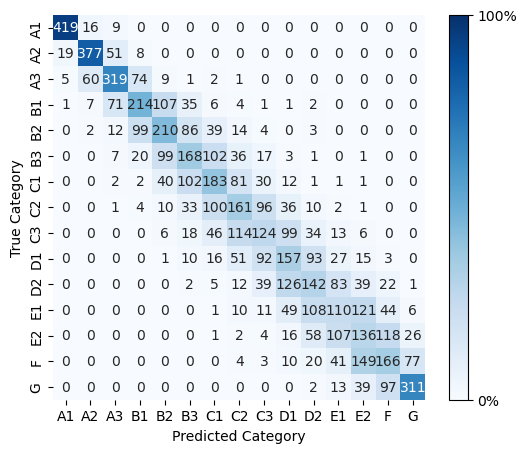

In [14]:
y_hat = model.predict(X_test)
cm = confusion_matrix(y_test, y_hat)

print("CM")
#print(cm)
heatmap(cm)

In [ ]:
dot_data = StringIO()
target_names = ["A3", "C1", "A2", "C2", "B3", "C3", "D1", "D2", "B2", "G", "E1", "B1", "F", "E2", "A1"]
export_graphviz(model, 
                out_file=dot_data,
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_names, 
                class_names = target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('BER_DecisionTree.png')
Image(graph.create_png())